In [104]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup

In [105]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from deepexperiment.utils import one_hot_encoding, one_hot_encoding_batch, ResBlock, get_indices
from deepexperiment.interpret import DeepShap

# Loading model and data

In [106]:
model = keras.models.load_model("../models/resnet_small_committee.h5")

In [107]:
samples = pd.read_csv('../data/positive_set_extended.csv')
print(len(samples))

18513


In [108]:
data, _ = one_hot_encoding_batch(samples)

# DeepSHAP

In [111]:
rand_samples = samples.sample(n=100, replace=False, random_state=42).reset_index(drop=True)
background, _ = one_hot_encoding_batch(rand_samples)
shaps = []

for i in range((len(data) // 1000) + 1):
    filename = f'../data/positive_set_shaps_{i}.npy'
    try:
        shap = np.load(filename)
        shaps.extend(shap)
        print(f'{filename} file exists.')
    except:
        print(f'{filename} file not found.')
        deepShap = DeepShap(model, background)
        data_sample = data[i*1000:(i+1)*1000]
        attribution = deepShap(data_sample)
        pos_shaps = attribution[1][:,:,:,0]
        shap = np.array(pos_shaps)
        shaps.extend(shap)
        np.save(filename, shaps)

../data/positive_set_shaps_0.npy file exists.
../data/positive_set_shaps_1.npy file exists.
../data/positive_set_shaps_2.npy file exists.
../data/positive_set_shaps_3.npy file exists.
../data/positive_set_shaps_4.npy file exists.
../data/positive_set_shaps_5.npy file exists.
../data/positive_set_shaps_6.npy file exists.
../data/positive_set_shaps_7.npy file exists.
../data/positive_set_shaps_8.npy file exists.
../data/positive_set_shaps_9.npy file exists.
../data/positive_set_shaps_10.npy file exists.
../data/positive_set_shaps_11.npy file exists.
../data/positive_set_shaps_12.npy file exists.
../data/positive_set_shaps_13.npy file exists.
../data/positive_set_shaps_14.npy file exists.
../data/positive_set_shaps_15.npy file exists.
../data/positive_set_shaps_16.npy file exists.
../data/positive_set_shaps_17.npy file exists.
../data/positive_set_shaps_18.npy file exists.


In [112]:
from deepexperiment.alignment import Attrament

attrament = Attrament()
align_x, align_s, align_y = [], [], []
for index, attr in enumerate(shaps):
    x, s, y = attrament(samples.iloc[index]['gene'], samples.iloc[index]['miRNA'][::-1], attr)
    align_x.append(x)
    align_s.append(s)
    align_y.append(y)

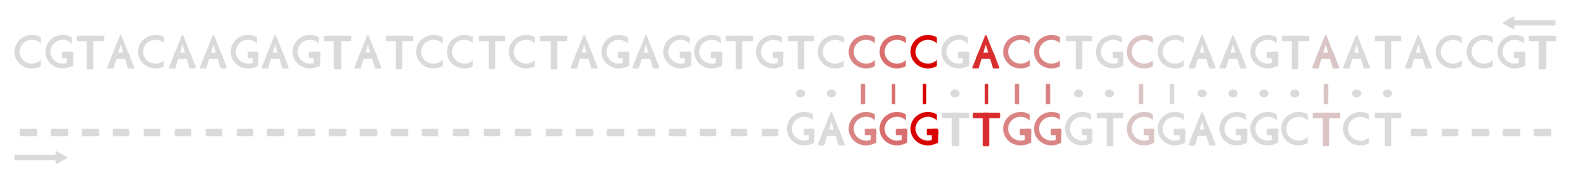

In [115]:
from deepexperiment.visualization import plot_alignment

plot_alignment(align_x[2], align_s[2], align_y[2])

# Clustering

In [116]:
miRNA_s = []
for j in range(len(align_y)):
    s = [align_s[j][i] for i in range(len(align_y[j])) if align_y[j][i] != "-"]
    # pad with zeros to the length of 20
    if len(s) < 20:
        s = s + [0] * (20 - len(s))
    miRNA_s.append(s)

miRNA_s = np.array(miRNA_s)

In [117]:
from sklearn.cluster import KMeans

N_CLUSTERS=5
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
kmeans.fit(miRNA_s)

KMeans(n_clusters=5, random_state=42)

In [118]:
labels = kmeans.labels_
labels

array([4, 3, 2, ..., 0, 4, 0], dtype=int32)

(array([4050., 3263., 4641., 3156., 3403.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. ]),
 <BarContainer object of 5 artists>)

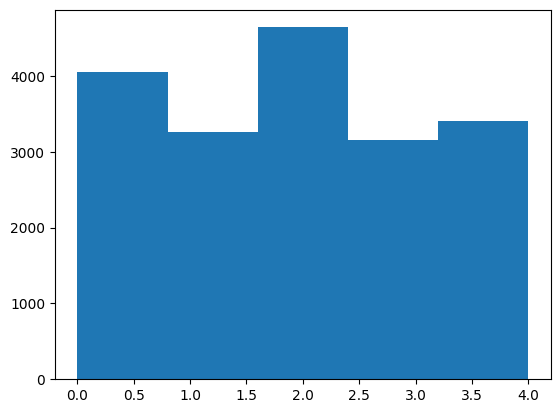

In [119]:
plt.hist(labels,bins=N_CLUSTERS)

In [120]:
from deepexperiment.clustering import compute_cluster_consensus

cluster_consensus = compute_cluster_consensus(miRNA_s, labels)

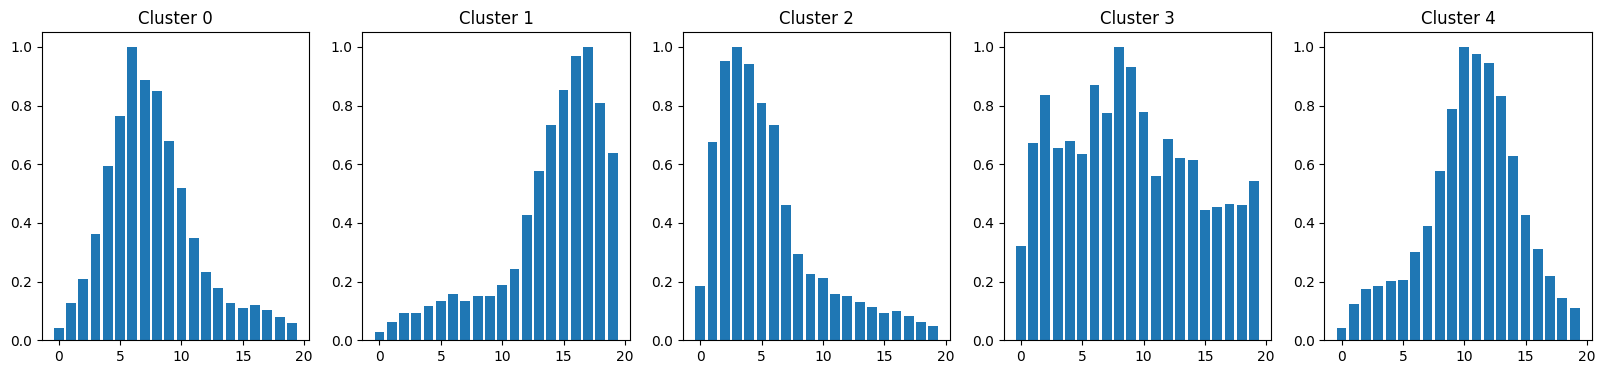

In [121]:
fig, ax = plt.subplots(1, 5, figsize=(20, 4))

for i in range(5):
    ax[i].bar(range(20), cluster_consensus[i])
    ax[i].set_title(f"Cluster {i}")

FixedFormatter should only be used together with FixedLocator
FixedFormatter should only be used together with FixedLocator


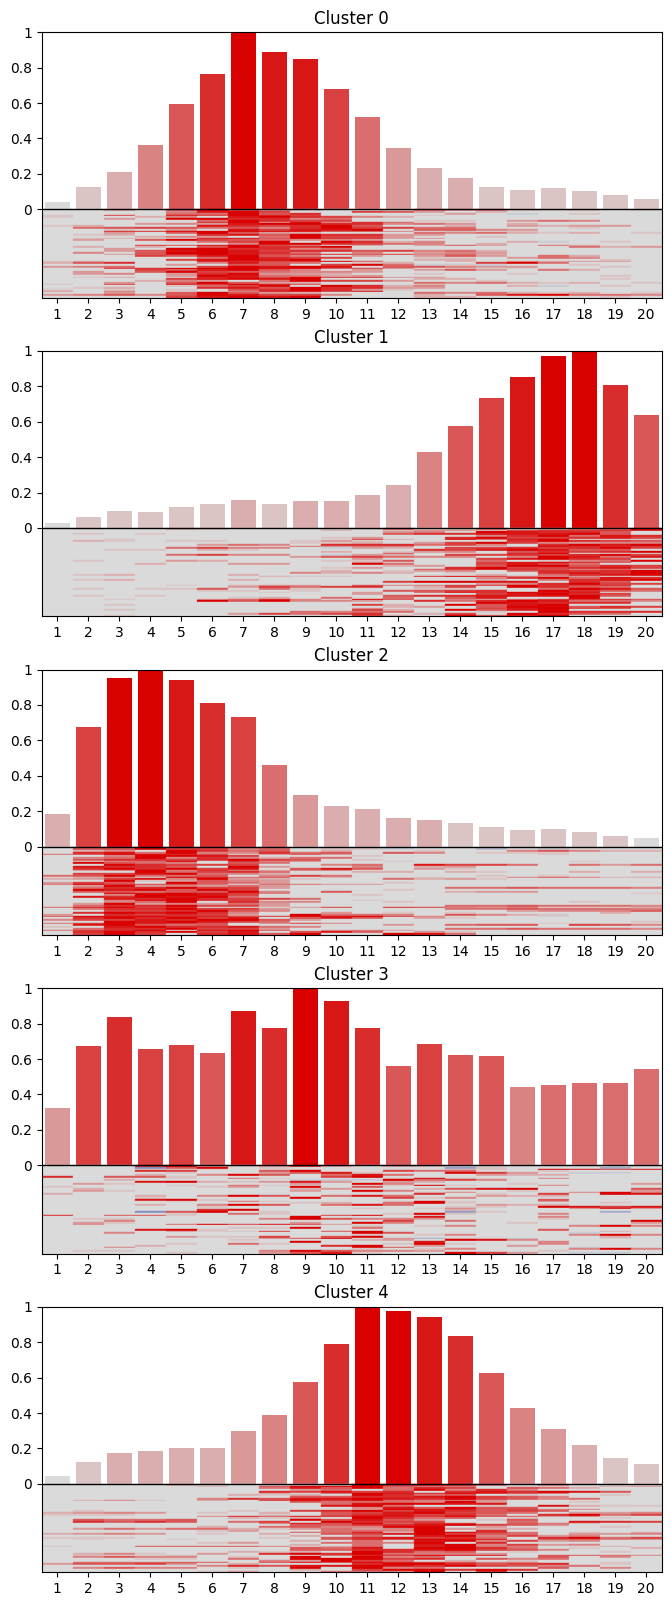

In [124]:
from deepexperiment.visualization import color_palette, plot_block

align_y = np.array(align_y, dtype=object)
align_s = np.array(align_s, dtype=object)

fig, ax = plt.subplots(5, 1, figsize=(8, 20))

for cluster in range(5):

    y_cluster, s_cluster = align_y[labels == cluster], align_s[labels == cluster]

    max_absolute_value = max(abs(np.array(cluster_consensus[cluster])))
    s = np.array(cluster_consensus[cluster]) / max_absolute_value
    s = s * 10 + 10

    for i in range(len(s)):
        ax[cluster].bar(x=i+1, height=cluster_consensus[cluster][i], color=color_palette[round(s[i])])

    ax[cluster].axhline(y=0, color='black', linestyle='-', linewidth=1)

    for i in range(50):
        index = np.random.randint(0, len(y))

        max_absolute_value = max(abs(np.array(s_cluster[index])))
        s = s_cluster[index] / max_absolute_value
        s = s * 10 + 10

        shift = 0.5
        height = 0.01

        miRNA = []
        miRNA_s = []
        for j in range(len(y_cluster[index])):
            if y_cluster[index][j] != "-":
                miRNA.append(y_cluster[index][j])
                miRNA_s.append(s[j])

        base = -1 * height * i - height
        for j in range(len(miRNA)):
            plot_block(ax[cluster], base, 1-shift + (1 * j), height, color_palette[round(miRNA_s[j])])


    ax[cluster].set_xlim(0.5, 20 + 0.5)
    ax[cluster].set_ylim(-0.5, 1)

    ax[cluster].set_xticklabels(np.arange(1, len(miRNA_s) + 1))
    ax[cluster].set_xticks(np.arange(1, len(miRNA_s) + 1))

    ax[cluster].set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax[cluster].set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])

    ax[cluster].set_title(f"Cluster {cluster}")